### <strong><font color=cornflowerblue>第五次作品：混合常態分配的參數之 MLE 估計與評估</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong><font color=lightseagreen>作品目標</font></strong>：
本作品針對兩組來自不同參數的混合常態分配樣本進行實驗，旨在探討利用最大概似估計法（MLE）準確估計出兩組資料各自的參數值，並通過蒙地卡羅模擬實驗，計算參數估計值的平均值（Mean）、偏差（Bias）以及均方根誤差（RMSE），以評估 MLE 的參數估計表現。此外，本作品亦採用 `sklearn.mixture.GaussianMixture` 方法對資料進行參數估計，並重複相同的模擬實驗步驟，比較該方法與 MLE 在參數估計結果上的表現差異。

<hr>

### <strong><font color=cornflowerblue>目標一</font></strong>：針對兩組來自不同參數的混合常態分配樣本進行實驗，探討利用最大概似估計法（MLE）準確估計出兩組資料各自的參數值。

- 機率密度函數（PDF）：
$$ f(x|\Omega) = \pi_1 f(x | \mu_1, \sigma_1^2) + \pi_2 f(x | \mu_2, \sigma_2^2) $$
其中 $\Omega = \{\pi_1, \pi_2, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2 | \pi_1 + \pi_2 = 1\} $

- 對數聯合概似函數的最大值：
$$max_{\Omega = \{\pi_1, \pi_2, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2 | \pi_1 + \pi_2 = 1, \pi_1, \pi_2, \sigma_1^2, \sigma_2^2 > 0 \}} L(\Omega)$$
其中目標函數為：
$$
\begin{align*}
L(\Omega) &= \ln \prod^{N}_{i = 1}(\pi_1 f(x_i | \mu_1, \sigma_1^2) + \pi_2 f(x_i | \mu_2, \sigma_2^2)) \\
&= \sum^{N}_{i = 1} \ln(\pi_1 f(x_i | \mu_1, \sigma_1^2) + \pi_2 f(x_i | \mu_2, \sigma_2^2))
\end{align*}
$$

**<font color=indianred>說明</font>**：分別決定出本次實驗的兩組樣本所來自的母體參數值，即混合常態分配之參數值，並繪圖呈現其分佈情況，以及加上組成該分配的兩組常態分配的分佈圖

- 第 1 組母體參數值：$\pi_1 = 0.8, \mu_1 = -2, \sigma_1 = 1, \mu_2 = 1, \sigma_2 = 0.5$
- 第 2 組母體參數值：$\pi_1 = 0.3, \mu_1 = -0.5, \sigma_1 = 1, \mu_2 = 1.5, \sigma_2 = 2$

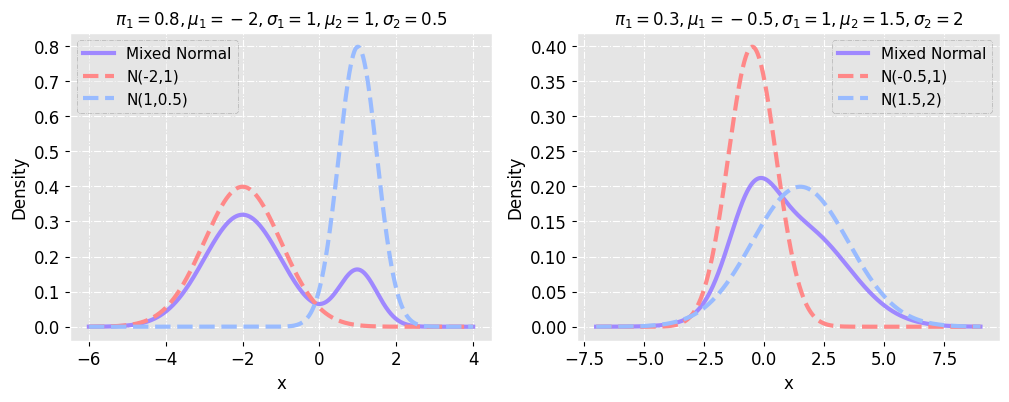

In [45]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

n = 100
pi1s = [0.8, 0.3]
mu1s, s1s = [-2, -0.5], [1, 1]
mu2s, s2s = [1, 1.5], [0.5, 2]
x_ranges = [-6, -7]
y_ranges = [4, 9]

plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for i, (pi1, mu1, s1, mu2, s2, x_range, y_range) in enumerate(zip(pi1s, mu1s, s1s, mu2s, s2s, x_ranges, y_ranges)):
    f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
    x = np.linspace(x_range, y_range, 1000)
    y = f(x)

    ax = axs.ravel()
    ax[i].plot(x, y, color = '#9F88FF', label = 'Mixed Normal', linewidth = 3)
    ax[i].plot(x, norm.pdf(x, mu1, s1), color = '#FF8888', linestyle = '--', linewidth = 3
               , label = 'N({},{})'.format(mu1, s1))
    ax[i].plot(x, norm.pdf(x, mu2, s2), color = '#99BBFF', linestyle = '--', linewidth = 3
               , label = 'N({},{})'.format(mu2, s2))
    ax[i].set_title('$\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$' \
                    .format(pi1, mu1, s1, mu2, s2), fontsize = 12, color = 'black')
    ax[i].set_xlabel('x', fontsize = 12, color = 'black')
    ax[i].set_ylabel('Density', fontsize = 12, color = 'black')
    ax[i].grid(True, linestyle = '-.')
    ax[i].tick_params(axis = 'both', labelsize = 12, colors = 'black')
    lgd = ax[i].legend(edgecolor = '#666666', prop = {'size': 11})
    lgd.get_frame().set_linestyle('-.')
    lgd.get_frame().set_alpha(0.4)

plt.show()

**<font color=indianred>說明</font>**：生成 n 個來自混合常態的隨機樣本，其中分佈參數 $\pi_1 = 0.8, \mu_1 = -2, \sigma_1 = 1, \mu_2 = 1, \sigma_2 = 0.5$，樣本數 n = 50，100，300，500，1000，2000，5000，10000，15000。針對每個樣本數 n 畫出樣本分佈直方圖，並利用 MLE 估計其參數值，畫出其樣本分佈圖，以及真實母體分佈圖，觀察它們之間隨著樣本數增加而產生的變化以及差異。

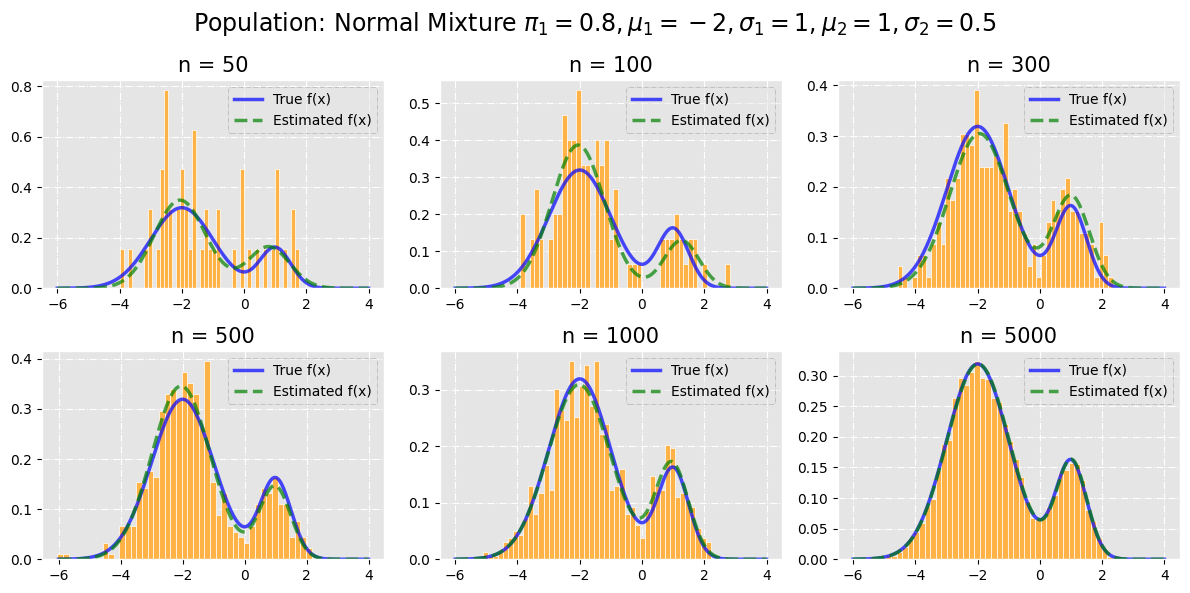

In [42]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# 設定參數
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.8
mu1, s1 = -2, 1
mu2, s2 = 1, 0.5

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-6, 4, 1000)
y = f(x)

# 設定演算法初始設定
params0 = [0.8, -2, 1, 1, 0.5]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

for j in range(len(n)):
    # 生成樣本
    n1 = binom.rvs(n[j], pi1)
    X = np.r_[norm.rvs(mu1, s1, size = n1), norm.rvs(mu2, s2, size = n[j] - n1)]

    # 定義 mixed normal 對數最大概似函數
    neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                            (1 - x[0]) * norm.pdf(X, x[3], x[4])))

    # 計算最大概似估計
    result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                    , bounds = bnd, options = opts)

    ax = axs.ravel()
    ax[j].plot(x, y, color = 'blue', label = 'True f(x)', linewidth = 2.5, alpha = 0.7)
    ax[j].plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
            (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)'
            , color = 'green', linewidth = 2.5, linestyle = '--', alpha = 0.7)
    ax[j].hist(X, bins = 45, density = True, color = '#FFB347', edgecolor = 'white')
    ax[j].set_title('n = {}'.format(n[j]), fontsize = 15)
    ax[j].grid(True, linestyle = '-.')
    ax[j].tick_params(axis = 'both', labelsize = 10, colors = 'black')
    lgd = ax[j].legend(edgecolor = '#666666', prop = {'size': 10})
    lgd.get_frame().set_linestyle('-.')
    lgd.get_frame().set_alpha(0.4)

fig.suptitle('Population: Normal Mixture $\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$' \
                .format(pi1, mu1, s1, mu2, s2), fontsize = 17)
plt.tight_layout()
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
- 華航

**<font color=lightseagreen>結論</font>**：
- 哈哈

<hr>

**<font color=indianred>說明</font>**：與前面實驗步驟相同，但其中分佈參數 $\pi_1 = 0.3, \mu_1 = -0.5, \sigma_1 = 1, \mu_2 = 1.5, \sigma_2 = 2$。

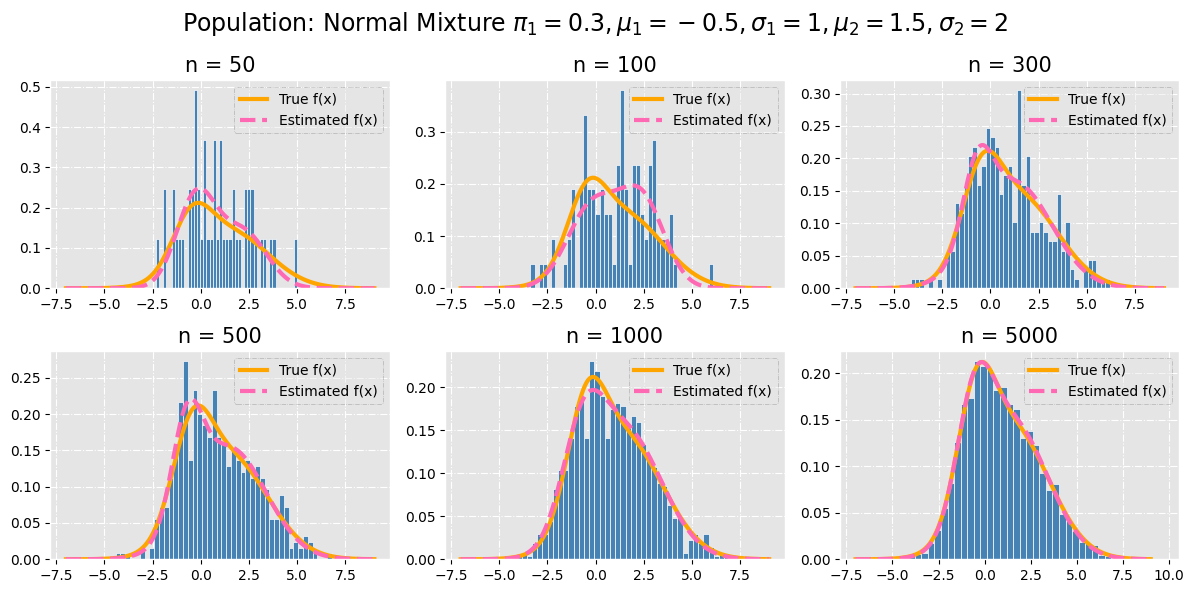

In [43]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# 設定參數
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.3
mu1, s1 = -0.5, 1
mu2, s2 = 1.5, 2

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-7, 9, 1000)
y = f(x)

# 設定演算法初始設定
params0 = [0.3, -0.5, 1, 1.5, 2]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

for j in range(len(n)):
    # 生成樣本
    n1 = binom.rvs(n[j], pi1)
    X = np.r_[norm.rvs(mu1, s1, size = n1), norm.rvs(mu2, s2, size = n[j] - n1)]

    # 定義 mixed normal 對數最大概似函數
    neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                            (1 - x[0]) * norm.pdf(X, x[3], x[4])))

    # 計算最大概似估計
    result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                    , bounds = bnd, options = opts)

    ax = axs.ravel()
    ax[j].plot(x, y, color = '#FFA500', label = 'True f(x)', linewidth = 3)
    ax[j].plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
            (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)'
            , color = '#FF69B4', linestyle = '--', linewidth = 3)
    ax[j].hist(X, bins = 45, density = True, color = '#4682B4', edgecolor = 'white')
    ax[j].set_title('n = {}'.format(n[j]), fontsize = 15)
    ax[j].grid(True, linestyle = '-.')
    ax[j].tick_params(axis = 'both', labelsize = 10, colors = 'black')
    lgd = ax[j].legend(edgecolor = '#666666', prop = {'size': 10})
    lgd.get_frame().set_linestyle('-.')
    lgd.get_frame().set_alpha(0.4)

fig.suptitle('Population: Normal Mixture $\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$' \
                .format(pi1, mu1, s1, mu2, s2), fontsize = 17)
plt.tight_layout()
plt.show()

#### **<font color=cornflowerblue>注意事項與討論：</font>**

**<font color=lightseagreen>觀察</font>**：
- 華航

**<font color=lightseagreen>結論</font>**：
- 哈哈

<hr>

### <strong><font color=cornflowerblue>目標二</font></strong>：通過蒙地卡羅模擬實驗，分別針對兩組樣本的參數估計值進行平均值（Mean）、偏差（Bias）以及均方根誤差（RMSE）的計算，評估 MLE 在參數估計上的表現。

1. Mean 計算：

    - 理論值：
    $$ Mean(\hat{\theta}) = E(\hat{\theta}) $$

    - 實驗值：
    $$
    \begin{align*}
    Mean(\hat{\theta}) &= \frac{1}{N}\sum_{k=1}^{N}\hat{\theta}_k \\
    &= \bar{\theta}
    \end{align*}
    $$

2. Bias 計算：

    - 理論值：
    $$ Bias(\hat{\theta}) = E(\hat{\theta}) - \theta $$

    - 實驗值：
    $$
    \begin{align*}
    Bias(\hat{\theta}) &= \frac{1}{N}\sum_{k=1}^{N}\hat{\theta}_k - \theta \\
    &= \bar{\theta} - \theta
    \end{align*}
    $$

3. Variance 計算：

    - 理論值：
    $$ Var(\hat{\theta}) = E[\hat{\theta} - E(\hat{\theta})]^2 $$

    - 實驗值：
    $$ Var(\hat{\theta}) = \frac{1}{N-1} \sum^{N}_{k=1} (\hat{\theta}_k - \bar{\theta})^2 $$

4. RMSE 計算：

    - 理論值：
    $$
    \begin{align*}
    RMSE(\hat{\theta}) &= \sqrt{MSE(\hat{\theta})} \\
    &= \sqrt{E(\hat{\theta} - \theta)^2}
    \end{align*}
    $$

    - 實驗值：
    $$
    \begin{align*}
    RMSE(\hat{\theta}) &= \sqrt{MSE(\hat{\theta})} \\
    &= \sqrt{\frac{1}{N} \sum^{N}_{k=1} (\hat{\theta}_k - \theta)^2}
    \end{align*}
    $$

In [130]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 設定參數
N = 100  # number of simulations
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.8
mu1, s1 = -2, 1
mu2, s2 = 1, 0.5

# 設定演算法初始設定
params0 = [0.8, -2, 1, 1, 0.5]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

mean_RESULT = np.zeros((len(n), len(params0)))
bias_RESULT = np.zeros((len(n), len(params0)))
rmse_RESULT = np.zeros((len(n), len(params0)))

for j in range(len(n)):
    RESULT = np.zeros((N, 5))
    # 生成來自 normal mixture 的資料
    n1 = binom.rvs(n[j], pi1)
    SAMPLE = np.r_[norm.rvs(mu1, s1, size = (n1, N)), \
                norm.rvs(mu2, s2, size = (n[j] - n1, N))]

    for i in range(N):
        X = SAMPLE[:, i]

        neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                    (1 - x[0]) * norm.pdf(X, x[3], x[4])))

        result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead', \
                        bounds = bnd, options = opts)
        RESULT[i, :] = result.x

    # Evaluation
    mean_RESULT[j, :] = np.mean(RESULT, axis = 0)
    bias_RESULT[j, :] = mean_RESULT[j, :] - params0
    rmse_RESULT[j, :] = np.sqrt(np.mean((RESULT - params0) ** 2, axis = 0))

結果顯示有問題

In [ ]:
# 整理表格
columns = ['pi1={}'.format(pi1), 'mu1={}'.format(mu1), 's1={}'.format(s1)
           , 'mu2={}'.format(mu2), 's2={}'.format(s2)]

columns_mean = pd.MultiIndex.from_product([['Mean for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])
columns_bias = pd.MultiIndex.from_product([['Bias for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])
columns_rmse = pd.MultiIndex.from_product([['RMSE for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])

df_mean = pd.DataFrame(mean_RESULT, index = n, columns = columns_mean)
df_bias = pd.DataFrame(bias_RESULT, index = n, columns = columns_bias)
df_rmse = pd.DataFrame(rmse_RESULT, index = n, columns = columns_rmse)

# 使用 Styler 对象来设置列名和单元格内容的对齐方式
df_mean1 = df_mean.style.set_table_styles({
    ('Mean for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_bias1 = df_bias.style.set_table_styles({
    ('Bias for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_rmse1 = df_rmse.style.set_table_styles({
    ('RMSE for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

# 添加水平線在每個 row
df_mean1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_bias1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_rmse1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)

# 显示 DataFrame
display(df_mean1)
display(df_bias1)
display(df_rmse1)

: 

演算法不同，會出現警告，因為計算的值會太小，Nelder-Mead 沒警告，L-BFGS-B 會有警告

##### other paras

In [131]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 設定參數
N = 100  # number of simulations
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.3
mu1, s1 = -0.5, 1
mu2, s2 = 1.5, 2

# 設定演算法初始設定
params0 = [0.3, -0.5, 1, 1.5, 2]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

mean_RESULT = np.zeros((len(n), len(params0)))
bias_RESULT = np.zeros((len(n), len(params0)))
rmse_RESULT = np.zeros((len(n), len(params0)))

for j in range(len(n)):
    RESULT = np.zeros((N, 5))
    # 生成來自 normal mixture 的資料
    n1 = binom.rvs(n[j], pi1)
    SAMPLE = np.r_[norm.rvs(mu1, s1, size = (n1, N)), \
                norm.rvs(mu2, s2, size = (n[j] - n1, N))]

    for i in range(N):
        X = SAMPLE[:, i]

        neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                    (1 - x[0]) * norm.pdf(X, x[3], x[4])))

        result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead', \
                        bounds = bnd, options = opts)
        RESULT[i, :] = result.x

    # Evaluation
    mean_RESULT[j, :] = np.mean(RESULT, axis = 0)
    bias_RESULT[j, :] = mean_RESULT[j, :] - params0
    rmse_RESULT[j, :] = np.sqrt(np.mean((RESULT - params0) ** 2, axis = 0))

c:\Users\Sheng\.vscode\env\statcomp\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Sheng\.vscode\env\statcomp\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: overflow encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\Sheng\.vscode\env\statcomp\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)
c:\Users\Sheng\.vscode\env\statcomp\Lib\site-packages\scipy\optimize\_optimize.py:835: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [ ]:
# 整理表格
columns = ['pi1={}'.format(pi1), 'mu1={}'.format(mu1), 's1={}'.format(s1)
           , 'mu2={}'.format(mu2), 's2={}'.format(s2)]

columns_mean = pd.MultiIndex.from_product([['Mean for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])
columns_bias = pd.MultiIndex.from_product([['Bias for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])
columns_rmse = pd.MultiIndex.from_product([['RMSE for the estimated parameters at N = {}'.format(N)], \
                                            pd.Index(columns, name = 'n')])

df_mean = pd.DataFrame(mean_RESULT, index = n, columns = columns_mean)
df_bias = pd.DataFrame(bias_RESULT, index = n, columns = columns_bias)
df_rmse = pd.DataFrame(rmse_RESULT, index = n, columns = columns_rmse)

# 使用 Styler 对象来设置列名和单元格内容的对齐方式
df_mean1 = df_mean.style.set_table_styles({
    ('Mean for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_bias1 = df_bias.style.set_table_styles({
    ('Bias for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_rmse1 = df_rmse.style.set_table_styles({
    ('RMSE for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

# 添加水平線在每個 row
df_mean1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_bias1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_rmse1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)

# 显示 DataFrame
display(df_mean1)
display(df_bias1)
display(df_rmse1)

: 

### <strong><font color=cornflowerblue>目標三</font></strong>：通過蒙地卡羅模擬實驗，分別針對兩組樣本的參數估計值進行平均值（Mean）、偏差（Bias）以及均方根誤差（RMSE）的計算，評估 MLE 在參數估計上的表現。



[ 0.78205627 -1.98063005  1.10329721  1.15997952  0.43346762]


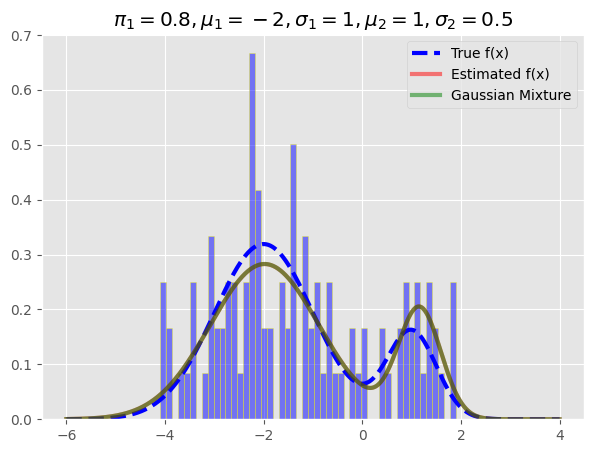

In [53]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 設定參數
n = 100
pi1 = 0.8
mu1, s1 = -2, 1
mu2, s2 = 1, 0.5

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-6, 4, 1000)
y = f(x)

# 生成樣本
n1 = binom.rvs(n, pi1)
n2 = n - n1
x1 = norm.rvs(mu1, s1, size = n1)
x2 = norm.rvs(mu2, s2, size = n2)
X = np.concatenate([x1, x2])

# 定義 mixed normal 對數最大概似函數
def neg_log_likelihood(params):
    pi1, mu1, s1, mu2, s2 = params
    f = lambda X: pi1 * norm.pdf(X, mu1, s1) + (1 - pi1) * norm.pdf(X, mu2, s2)
    return -np.sum(np.log(f(X)))

# 設定演算法初始設定
params0 = [0.8, -2, 1, 1, 0.5]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}
result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                  , bounds = bnd, options = opts)
print(result.x)

gmm = GaussianMixture(n_components=2, covariance_type='full',\
            verbose = 0, max_iter = 1000, tol = 1e-6)
gmm.fit(X.reshape(-1, 1)) # sample is the normal mixture data as a column vector

plt.style.use('ggplot')
fig = plt.figure(figsize = (7, 5))
plt.plot(x, y, color = 'blue', label = 'True f(x)', linewidth = 3, linestyle = '--')
plt.plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
         (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)'
         , color = 'red', linewidth = 3, alpha = 0.5)
plt.plot(x, gmm.weights_[0] * norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) + \
            gmm.weights_[1] * norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0]))
            , label = 'Gaussian Mixture', color = 'green', linewidth = 3, alpha = 0.5)
plt.hist(X, bins = 50, density = True, color = 'blue', edgecolor = 'yellow', alpha = 0.5)
plt.title('$\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$'.format(pi1, mu1, s1, mu2, s2))
plt.legend()
plt.show()

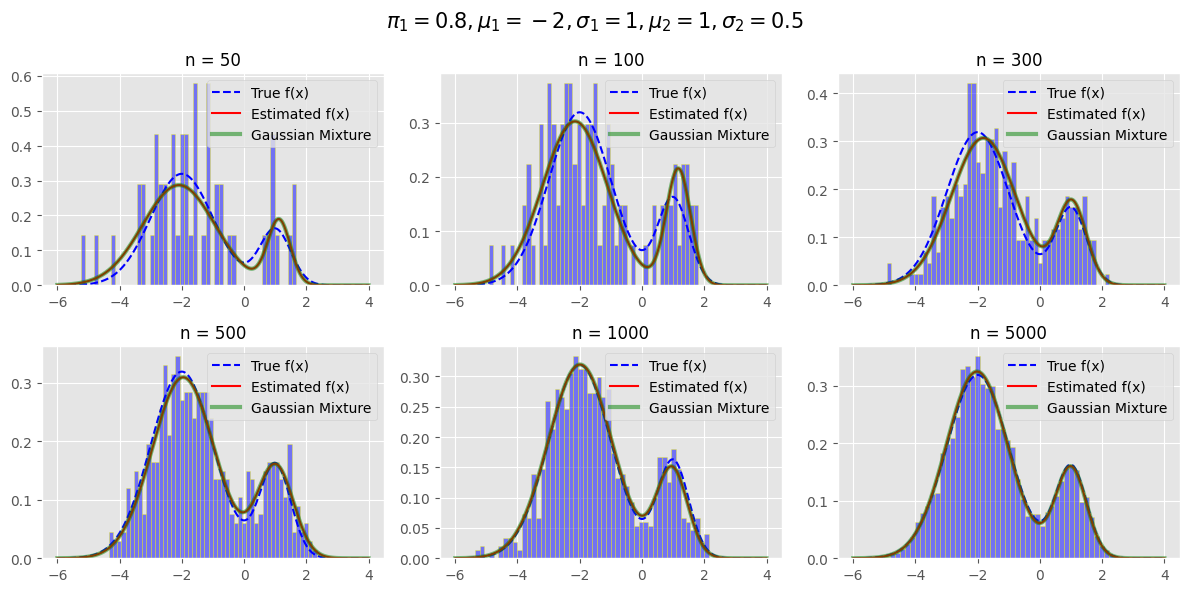

In [2]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 設定參數
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.8
mu1, s1 = -2, 1
mu2, s2 = 1, 0.5

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-6, 4, 1000)
y = f(x)

# 設定演算法初始設定
params0 = [0.8, -2, 1, 1, 0.5]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

for j in range(len(n)):
    # 生成樣本
    n1 = binom.rvs(n[j], pi1)
    X = np.r_[norm.rvs(mu1, s1, size = n1), norm.rvs(mu2, s2, size = n[j] - n1)]

    # 定義 mixed normal 對數最大概似函數
    neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                            (1 - x[0]) * norm.pdf(X, x[3], x[4])))

    # 計算最大概似估計
    result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                    , bounds = bnd, options = opts)
    
    # Gaussian Mixture 演算法
    gmm = GaussianMixture(n_components = 2, covariance_type = 'full', \
            verbose = 0, max_iter = 1000, tol = 1e-6)
    gmm.fit(X.reshape(-1, 1)) # sample is the normal mixture data as a column vector

    ax = axs.ravel()
    ax[j].plot(x, y, color = 'blue', label = 'True f(x)', linestyle = '--')
    ax[j].plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
            (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)', color = 'red')
    ax[j].plot(x, gmm.weights_[0] * norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) + \
             gmm.weights_[1] * norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])) \
                , label = 'Gaussian Mixture', color = 'green', linewidth = 3, alpha = 0.5)
    ax[j].hist(X, bins = 50, density = True, color = 'blue', edgecolor = 'yellow', alpha = 0.5)
    ax[j].set_title('n = {}'.format(n[j]), fontsize = 12)
    ax[j].legend()

fig.suptitle('$\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$' \
                .format(pi1, mu1, s1, mu2, s2), fontsize = 15)
plt.tight_layout()
plt.show()

[ 0.26137663 -0.38022105  0.85802917  1.34928598  1.95807632]


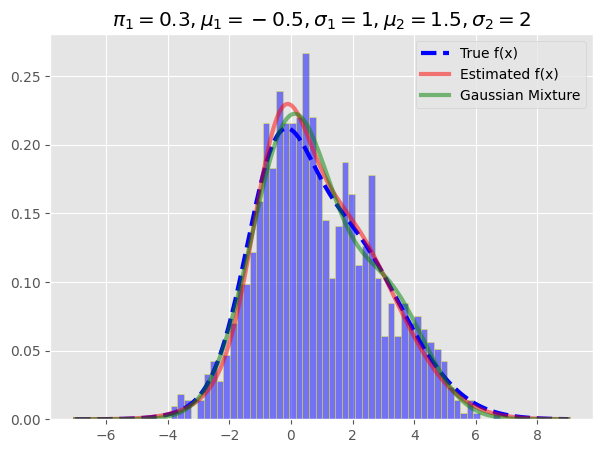

In [44]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 設定參數
n = 1000
pi1 = 0.3
mu1, s1 = -0.5, 1
mu2, s2 = 1.5, 2

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-7, 9, 1000)
y = f(x)

# 生成樣本
n1 = binom.rvs(n, pi1)
n2 = n - n1
x1 = norm.rvs(mu1, s1, size = n1)
x2 = norm.rvs(mu2, s2, size = n2)
X = np.concatenate([x1, x2])

# 定義 mixed normal 對數最大概似函數
def neg_log_likelihood(params):
    pi1, mu1, s1, mu2, s2 = params
    f = lambda X: pi1 * norm.pdf(X, mu1, s1) + (1 - pi1) * norm.pdf(X, mu2, s2)
    return -np.sum(np.log(f(X)))

# 設定演算法初始設定
params0 = [0.3, -0.5, 1, 1.5, 2]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}
result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                  , bounds = bnd, options = opts)
print(result.x)

gmm = GaussianMixture(n_components=2, covariance_type='full',\
            verbose = 0, max_iter = 1000, tol = 1e-6)
gmm.fit(X.reshape(-1, 1)) # sample is the normal mixture data as a column vector

plt.style.use('ggplot')
fig = plt.figure(figsize = (7, 5))
plt.plot(x, y, color = 'blue', label = 'True f(x)', linewidth = 3, linestyle = '--')
plt.plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
         (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)'
         , color = 'red', linewidth = 3, alpha = 0.5)
plt.plot(x, gmm.weights_[0] * norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) + \
            gmm.weights_[1] * norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0]))
            , label = 'Gaussian Mixture', color = 'green', linewidth = 3, alpha = 0.5)
plt.hist(X, bins = 50, density = True, color = 'blue', edgecolor = 'yellow', alpha = 0.5)
plt.title('$\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$'.format(pi1, mu1, s1, mu2, s2))
plt.legend()
plt.show()

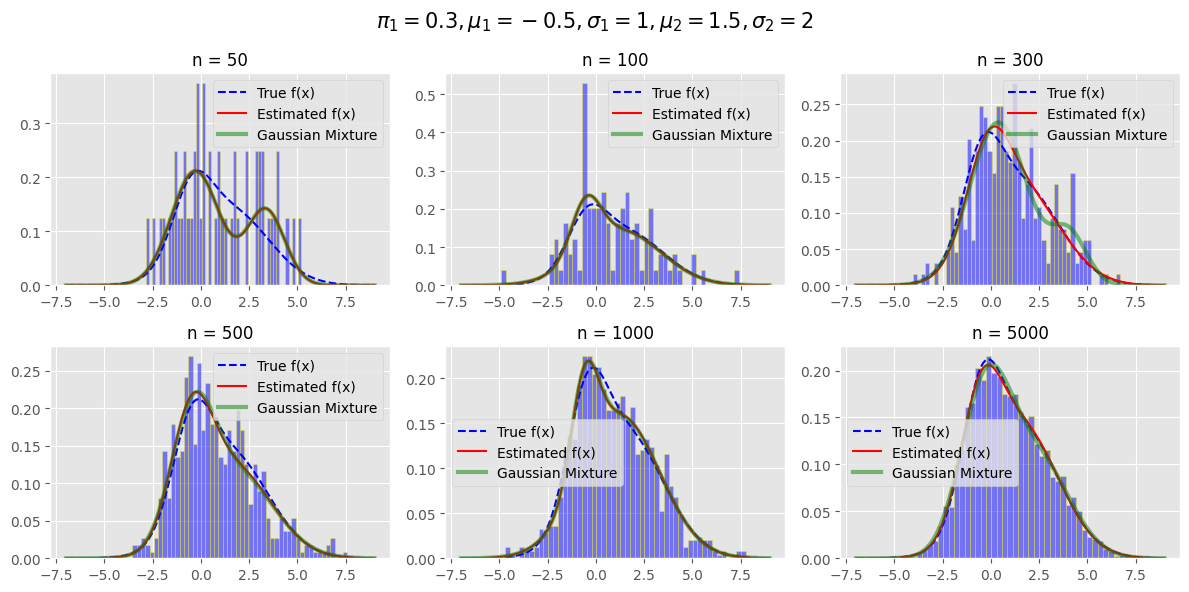

In [1]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 設定參數
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.3
mu1, s1 = -0.5, 1
mu2, s2 = 1.5, 2

# 理論混合常態分配 pdf
f = lambda x: pi1 * norm.pdf(x, mu1, s1) + (1 - pi1) * norm.pdf(x, mu2, s2)
x = np.linspace(-7, 9, 1000)
y = f(x)

# 設定演算法初始設定
params0 = [0.3, -0.5, 1, 1.5, 2]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

for j in range(len(n)):
    # 生成樣本
    n1 = binom.rvs(n[j], pi1)
    X = np.r_[norm.rvs(mu1, s1, size = n1), norm.rvs(mu2, s2, size = n[j] - n1)]

    # 定義 mixed normal 對數最大概似函數
    neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                            (1 - x[0]) * norm.pdf(X, x[3], x[4])))

    # 計算最大概似估計
    result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead'
                    , bounds = bnd, options = opts)
    
    # Gaussian Mixture 演算法
    gmm = GaussianMixture(n_components = 2, covariance_type = 'full', \
            verbose = 0, max_iter = 1000, tol = 1e-6)
    gmm.fit(X.reshape(-1, 1)) # sample is the normal mixture data as a column vector

    ax = axs.ravel()
    ax[j].plot(x, y, color = 'blue', label = 'True f(x)', linestyle = '--')
    ax[j].plot(x, result.x[0] * norm.pdf(x, result.x[1], result.x[2]) + \
            (1 - result.x[0]) * norm.pdf(x, result.x[3], result.x[4]), label = 'Estimated f(x)', color = 'red')
    ax[j].plot(x, gmm.weights_[0] * norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) + \
             gmm.weights_[1] * norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])) \
                , label = 'Gaussian Mixture', color = 'green', linewidth = 3, alpha = 0.5)
    ax[j].hist(X, bins = 50, density = True, color = 'blue', edgecolor = 'yellow', alpha = 0.5)
    ax[j].set_title('n = {}'.format(n[j]), fontsize = 12)
    ax[j].legend()

fig.suptitle('$\pi_1 = {}, \mu_1 = {}, \sigma_1 = {}, \mu_2 = {}, \sigma_2 = {}$' \
                .format(pi1, mu1, s1, mu2, s2), fontsize = 15)
plt.tight_layout()
plt.show()

##### 計算 RMSE

In [109]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture

# 設定參數
N = 50  # number of simulations
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.8
mu1, s1 = -2, 1
mu2, s2 = 1, 0.5

# 設定演算法初始設定
params0 = [0.8, -2, 1, 1, 0.5]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

mean_mini = np.zeros((len(n), len(params0))); mean_gmm = np.zeros((len(n), len(params0)))
bias_mini = np.zeros((len(n), len(params0))); bias_gmm = np.zeros((len(n), len(params0)))
rmse_mini = np.zeros((len(n), len(params0))); rmse_gmm = np.zeros((len(n), len(params0)))

for j in range(len(n)):
    # 生成結果矩陣
    RESULT_mini = np.zeros((N, 5))
    RESULT_gmm = np.zeros((N, 5))
    # 生成來自 mix beta distribution 的資料
    n1 = binom.rvs(n[j], pi1)
    SAMPLE = np.r_[norm.rvs(mu1, s1, size = (n1, N)), \
                norm.rvs(mu2, s2, size = (n[j] - n1, N))]

    for i in range(N):
        X = SAMPLE[:, i]

        neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                    (1 - x[0]) * norm.pdf(X, x[3], x[4])))

        result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead', \
                        bounds = bnd, options = opts)
        RESULT_mini[i, :] = result.x

        # Gaussian Mixture 演算法
        gmm = GaussianMixture(n_components = 2, covariance_type = 'full', \
                verbose = 0, max_iter = 8000, tol = 1e-6)
        gmm.fit(X.reshape(-1, 1))
        a, b = np.argmax(gmm.weights_), np.argmin(gmm.weights_)
        RESULT_gmm[i, :] = [gmm.weights_[a], gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0][0]), \
                             gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0][0])]

    # minimize
    mean_mini[j, :] = np.mean(RESULT_mini, axis = 0)
    bias_mini[j, :] = mean_mini[j, :] - params0
    rmse_mini[j, :] = np.sqrt(np.mean((RESULT_mini - params0) ** 2, axis = 0))

    # gmm
    mean_gmm[j, :] = np.mean(RESULT_gmm, axis = 0)
    bias_gmm[j, :] = mean_gmm[j, :] - params0
    rmse_gmm[j, :] = np.sqrt(np.mean((RESULT_gmm - params0) ** 2, axis = 0))

In [ ]:
# 整理表格
columns = ['pi1={}'.format(pi1), 'mu1={}'.format(mu1), 's1={}'.format(s1)
           , 'mu2={}'.format(mu2), 's2={}'.format(s2)]

# 创建 MultiIndex 列名
columns_mean = pd.MultiIndex.from_product([['Mean for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])
columns_bias = pd.MultiIndex.from_product([['Bias for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])
columns_rmse = pd.MultiIndex.from_product([['RMSE for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])

# 创建新的 MultiIndex
methods = np.repeat(['optimize.minimize', 'GaussianMixture'], len(n))
ns = np.tile(n, 2)
multi_index = pd.MultiIndex.from_arrays([methods, ns])

# 创建 DataFrame 并设置 MultiIndex
df_mean = pd.DataFrame(np.vstack([mean_mini, mean_gmm]), index=multi_index, columns=columns_mean)
df_bias = pd.DataFrame(np.vstack([bias_mini, bias_gmm]), index=multi_index, columns=columns_bias)
df_rmse = pd.DataFrame(np.vstack([rmse_mini, rmse_gmm]), index=multi_index, columns=columns_rmse)

# 使用 Styler 对象来设置列名和单元格内容的对齐方式
df_mean1 = df_mean.style.set_table_styles({
    ('Mean for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_bias1 = df_bias.style.set_table_styles({
    ('Bias for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_rmse1 = df_rmse.style.set_table_styles({
    ('RMSE for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

# 添加水平線在每個 row
df_mean1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_bias1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_rmse1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)

# 显示 DataFrame
display(df_mean1)
display(df_bias1)
display(df_rmse1)

##### other paras

In [125]:
from scipy.stats import norm, binom
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture

# 設定參數
N = 50  # number of simulations
n = [50, 100, 300, 500, 1000, 5000]
pi1 = 0.3
mu1, s1 = -0.5, 1
mu2, s2 = 1.5, 2

# 設定演算法初始設定
params0 = [0.3, -0.5, 1, 1.5, 2]
bnd = [(0, 1), (None, None), (None, None), (None, None), (None, None)]
opts = {'disp': False, 'maxiter': 8000}

mean_mini = np.zeros((len(n), len(params0))); mean_gmm = np.zeros((len(n), len(params0)))
bias_mini = np.zeros((len(n), len(params0))); bias_gmm = np.zeros((len(n), len(params0)))
rmse_mini = np.zeros((len(n), len(params0))); rmse_gmm = np.zeros((len(n), len(params0)))

for j in range(len(n)):
    # 生成結果矩陣
    RESULT_mini = np.zeros((N, 5))
    RESULT_gmm = np.zeros((N, 5))
    # 生成來自 mix beta distribution 的資料
    n1 = binom.rvs(n[j], pi1)
    SAMPLE = np.r_[norm.rvs(mu1, s1, size = (n1, N)), \
                norm.rvs(mu2, s2, size = (n[j] - n1, N))]

    for i in range(N):
        X = SAMPLE[:, i]

        neg_log_likelihood = lambda x: -np.sum(np.log(x[0] * norm.pdf(X, x[1], x[2]) + \
                                    (1 - x[0]) * norm.pdf(X, x[3], x[4])))

        result = minimize(neg_log_likelihood, params0, method = 'Nelder-Mead', \
                        bounds = bnd, options = opts)
        RESULT_mini[i, :] = result.x

        # Gaussian Mixture 演算法
        gmm = GaussianMixture(n_components = 2, covariance_type = 'full', \
                verbose = 0, max_iter = 8000, tol = 1e-6)
        gmm.fit(X.reshape(-1, 1))
        a, b = np.argmax(gmm.weights_), np.argmin(gmm.weights_)
        RESULT_gmm[i, :] = [gmm.weights_[a], gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0][0]), \
                             gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0][0])]

    # minimize
    mean_mini[j, :] = np.mean(RESULT_mini, axis = 0)
    bias_mini[j, :] = mean_mini[j, :] - params0
    rmse_mini[j, :] = np.sqrt(np.mean((RESULT_mini - params0) ** 2, axis = 0))

    # gmm
    mean_gmm[j, :] = np.mean(RESULT_gmm, axis = 0)
    bias_gmm[j, :] = mean_gmm[j, :] - params0
    rmse_gmm[j, :] = np.sqrt(np.mean((RESULT_gmm - params0) ** 2, axis = 0))

In [126]:
# 整理表格
columns = ['pi1={}'.format(pi1), 'mu1={}'.format(mu1), 's1={}'.format(s1)
           , 'mu2={}'.format(mu2), 's2={}'.format(s2)]

# 创建 MultiIndex 列名
columns_mean = pd.MultiIndex.from_product([['Mean for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])
columns_bias = pd.MultiIndex.from_product([['Bias for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])
columns_rmse = pd.MultiIndex.from_product([['RMSE for the estimated parameters at N = {}'.format(N)], pd.Index(columns, name='n')])

# 创建新的 MultiIndex
methods = np.repeat(['optimize.minimize', 'GaussianMixture'], len(n))
ns = np.tile(n, 2)
multi_index = pd.MultiIndex.from_arrays([methods, ns])

# 创建 DataFrame 并设置 MultiIndex
df_mean = pd.DataFrame(np.vstack([mean_mini, mean_gmm]), index=multi_index, columns=columns_mean)
df_bias = pd.DataFrame(np.vstack([bias_mini, bias_gmm]), index=multi_index, columns=columns_bias)
df_rmse = pd.DataFrame(np.vstack([rmse_mini, rmse_gmm]), index=multi_index, columns=columns_rmse)

# 使用 Styler 对象来设置列名和单元格内容的对齐方式
df_mean1 = df_mean.style.set_table_styles({
    ('Mean for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Mean for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_bias1 = df_bias.style.set_table_styles({
    ('Bias for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('Bias for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

df_rmse1 = df_rmse.style.set_table_styles({
    ('RMSE for the estimated parameters at N = {}'.format(N), 'pi1={}'.format(pi1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu1={}'.format(mu1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's1={}'.format(s1)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 'mu2={}'.format(mu2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('RMSE for the estimated parameters at N = {}'.format(N), 's2={}'.format(s2)): [{'selector': 'th', 'props': [('text-align', 'center')]}],
}, overwrite=False).set_properties(**{'text-align': 'center'})

# 添加水平線在每個 row
df_mean1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_bias1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)
df_rmse1.set_table_styles([{'selector': 'tr', 'props': [('border-top', '1px solid #666666')]}], overwrite=False)

# 显示 DataFrame
display(df_mean1)
display(df_bias1)
display(df_rmse1)